In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import copy
from copy import deepcopy
import sys
import cv2
import os
import pandas as pd
import numpy as np
import random
from pathlib import Path

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [2]:
metadata = pd.read_csv('../doby_meta.csv')
metadata = metadata[metadata['subject_id'] < 16000000]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4198 entries, 0 to 4197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      4198 non-null   int64 
 1   study_id        4198 non-null   int64 
 2   dicom_id        4198 non-null   object
 3   DicomPath       4198 non-null   object
 4   edema_severity  4198 non-null   int64 
 5   normal          4198 non-null   int64 
 6   CHF             4198 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 233.7+ KB


In [3]:
SEG_BASE_PATH = '../chest-x-ray-dataset-with-lung-segmentation-1.0.0/chest-x-ray-dataset-with-lung-segmentation-1.0.0'
ORIG_BASE_PATH = '../physionet.org/files/mimic-cxr-jpg/2.0.0'

In [4]:
class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, x_seg, x_orig):
        return x_seg, x_orig.resize((self.size, self.size))

class MixImage(object):
    def __call__(self, fore, back):
        back.paste(fore, (0, 0), fore)
        return back

TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class Dataset(Dataset):
    def __init__(self, metadata, seg_base_path, orig_base_path, transform=None):
        self.metadata = metadata
        self.seg_base_path = Path(seg_base_path)
        self.orig_base_path = Path(orig_base_path)
        self.transform = transform

    def __getitem__(self, idx):
        x_path = self.metadata.loc[idx, 'DicomPath']
        x_seg_mask_path = self.seg_base_path / Path(x_path[:-4] + '-mask.jpg')
        x_seg_path = self.seg_base_path / Path(x_path)
        x_orig_path = self.orig_base_path / Path(x_path)

        x_seg = cv2.imread(str(x_seg_path), cv2.IMREAD_GRAYSCALE)
        x_seg = cv2.resize(x_seg, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        x_seg_mask = cv2.imread(str(x_seg_mask_path), cv2.IMREAD_GRAYSCALE)
        x_seg_mask = cv2.resize(x_seg_mask, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        x_orig = cv2.imread(str(x_orig_path), cv2.IMREAD_GRAYSCALE)
        x_orig = cv2.resize(x_orig, dsize=(64, 64), interpolation=cv2.INTER_AREA)

        # 노이즈 제거
        seg_mask1 = np.where(x_seg_mask > 128, 1, 0) # 128 threshold
        # 반전 마스크 및 노이즈 제거
        seg_mask2 = np.where(x_seg_mask < 128, 1, 0) # 128 threshold

        x_lung_seg = x_orig*seg_mask1

        # Gaussian Blur 적용
        x_orig_blur = Image.fromarray(x_orig).convert('L')
        x_orig_blur = x_orig_blur.filter(ImageFilter.GaussianBlur(1))
        x_orig_blur = np.array(x_orig_blur)

        # Lung Segmentation 제외 제거
        x_background = x_orig_blur*seg_mask2 # lung segmentation 제외 비우기
        seg_mask3 = np.where(x_seg_mask > 128, 255, 0).astype(np.uint8) # 타입 CV_8U 오류 방지

        # Background에 Lung Segmentation 붙이기
        x_merge = cv2.copyTo(x_lung_seg, seg_mask3, x_background)
        x_merge = Image.fromarray(x_merge).convert('L')
        
        # Histogram Equalization
        x_merge = ImageOps.equalize(x_merge)
        
        y = self.metadata.loc[idx, 'normal']

        if self.transform:
            x = self.transform(x_merge)

        return x, y

    def __len__(self):
        return self.metadata['normal'].count()

In [6]:
ds = Dataset(metadata, SEG_BASE_PATH, ORIG_BASE_PATH, transform=TRANSFORMS)

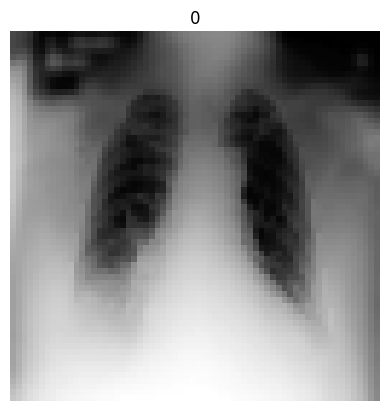

In [7]:
from torchvision.transforms.functional import to_pil_image

x, y = ds[201]
plt.title(y)
plt.imshow(to_pil_image(x), cmap='gray')
plt.axis('off')
plt.show()

In [8]:
ds_size = len(ds)
train_size = int(ds_size * 0.8)
test_size = ds_size - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size], generator=torch.manual_seed(42))

In [9]:
print(len(train_ds), len(test_ds))

3358 840


In [10]:
train_ds = copy(train_ds)

TRAIN_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    # rotation degree = -10, 10
    # translate -img_width * a < dx < img_width * a
        # -11.2 < dx < 11.2, y도 b로 마찬가지, tuple 형태로
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))
])

train_ds.dataset.transform = TRAIN_TRANSFORM

In [11]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True)

In [12]:
class CusVgg16(nn.Module):
    def __init__(self):
        super(CusVgg16, self).__init__()
        self.vgg = models.vgg16(weights='IMAGENET1K_V1')
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.vgg.classifier[6] = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.vgg(x)
        x = self.sigmoid(x)

        return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CusVgg16()
model.to(device)

CusVgg16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [14]:
i = 0
for name, param in model.named_parameters():
    print(i, name)
    i += 1

0 vgg.features.0.weight
1 vgg.features.0.bias
2 vgg.features.2.weight
3 vgg.features.2.bias
4 vgg.features.5.weight
5 vgg.features.5.bias
6 vgg.features.7.weight
7 vgg.features.7.bias
8 vgg.features.10.weight
9 vgg.features.10.bias
10 vgg.features.12.weight
11 vgg.features.12.bias
12 vgg.features.14.weight
13 vgg.features.14.bias
14 vgg.features.17.weight
15 vgg.features.17.bias
16 vgg.features.19.weight
17 vgg.features.19.bias
18 vgg.features.21.weight
19 vgg.features.21.bias
20 vgg.features.24.weight
21 vgg.features.24.bias
22 vgg.features.26.weight
23 vgg.features.26.bias
24 vgg.features.28.weight
25 vgg.features.28.bias
26 vgg.classifier.0.weight
27 vgg.classifier.0.bias
28 vgg.classifier.3.weight
29 vgg.classifier.3.bias
30 vgg.classifier.6.weight
31 vgg.classifier.6.bias


In [15]:
i = 0
for name, param in model.named_parameters():
    if i == 0 or i == 1 or i == 30 or i == 31:
        print('requires_grad = True')
    else:
        param.requires_grad = False
    i += 1

requires_grad = True
requires_grad = True
requires_grad = True
requires_grad = True


In [16]:
print(model.vgg.features[0].weight.requires_grad)
print(model.vgg.features[0].bias.requires_grad)
print(model.vgg.classifier[6].weight.requires_grad)
print(model.vgg.classifier[6].bias.requires_grad)
print(model.vgg.classifier[3].bias.requires_grad)

True
True
True
True
False


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
schedular = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
weights = (metadata['normal'] == 1).sum() / (metadata['normal'] == 0).sum()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weights])).to(device)

In [18]:
def train(model, data_loader, optimizer, epoch):
    model.train()
    running_loss = 0
    running_acc = 0
    n_data = 0

    for batch_idx, (batch, target) in enumerate(data_loader, start=1):
        batch, target = batch.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(batch)
        # print(output.shape, target.shape)
        target_ = target
        target = target.unsqueeze(dim=-1).float()

        loss = loss_fn(output, target)
        running_loss += loss.item()

        predicted = (output >= torch.FloatTensor([0.5]).to(device)).type(torch.float32)
        correct = (predicted == target).sum().item()
        running_acc += correct

        loss.backward()
        optimizer.step()

        n_data += len(batch)
        print(f'\rTrain Epoch: {epoch} [{n_data}/{len(data_loader.dataset)} ({100 * batch_idx / len(data_loader):.2f}%)]  Accuracy: {100*running_acc/n_data:.2f}%  Loss: {running_loss/batch_idx:.4f}', end='')

In [19]:
def test(model, data_loader):
    model.eval()
    test_acc = 0
    test_loss = 0
    n_data = 0
    TP, FP, TN, FN = 0, 0, 0, 0
    with torch.no_grad():
        for batch, target in data_loader:
            batch, target = batch.to(device), target.to(device)

            output = model(batch)
            target = target.unsqueeze(dim=-1).float()

            loss = loss_fn(output, target)
            test_loss += loss.item()

            predicted = (output >= torch.FloatTensor([0.5]).to(device)).type(torch.float32)
            correct = (predicted == target).sum().item()
            test_acc += correct

            TP += ((predicted == target) & (target == 1)).sum().item()
            FP += ((predicted != target) & (target == 0)).sum().item()
            TN += ((predicted == target) & (target == 0)).sum().item()
            FN += ((predicted != target) & (target == 1)).sum().item()
            
            n_data += len(batch)
            print(f'\rTest set: [{100*n_data/len(data_loader.dataset):.2f}%]', end='')
    
    test_acc = 100 * test_acc / len(data_loader.dataset)
    test_loss = test_loss / len(data_loader)
    
    print(f'\rTest set: Accuracy: {test_acc:.2f}%  Loss: {test_loss:.4f}')

    return test_acc, test_loss, TP, FP, TN, FN

In [20]:
def getMetric(TP, FP, TN, FN):
    # base case: divide by zero
    TP = 0.1 if TP == 0 else TP
    FP = 0.1 if FP == 0 else FP
    TN = 0.1 if TN == 0 else TN
    FN = 0.1 if FN == 0 else FN
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*precision*recall/(precision+recall)
    return sensitivity, specificity, f1_score

In [21]:
accs = []
losses = []
best_acc = 0
best_f1 = 0

best_acc_model = None
best_acc_model_state = None
best_f1_model = None
best_f1_model_state = None

In [22]:
for epoch in range(1, 30+1):
    train(model, train_dl, optimizer, epoch)
    
    print()
    
    acc, loss, tp, fp, tn, fn = test(model, test_dl)
    sensitivity, specificity, f1_score = getMetric(tp, fp, tn, fn)
    print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
    print(f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, F1-Score: {f1_score:.4f}')

    if acc > best_acc:
        best_acc = acc
        best_acc_model = deepcopy(model)
        best_acc_model_state = deepcopy(model.state_dict())

    if f1_score > best_f1:
        best_f1 = f1_score
        best_f1_model = deepcopy(model)
        best_f1_model_state = deepcopy(model.state_dict())
        
    schedular.step(loss)
    accs.append(acc)
    losses.append(loss)

    print('================================================================')

Train Epoch: 1 [3358/3358 (100.00%)]  Accuracy: 59.95%  Loss: 0.7792
Test set: Accuracy: 58.33%  Loss: 0.7683
TP: 313, FP: 162, TN: 177, FN: 188
Sensitivity: 0.6248, Specificity: 0.5221, F1-Score: 0.6414
Train Epoch: 2 [3358/3358 (100.00%)]  Accuracy: 60.93%  Loss: 0.7696
Test set: Accuracy: 60.83%  Loss: 0.7696
TP: 363, FP: 191, TN: 148, FN: 138
Sensitivity: 0.7246, Specificity: 0.4366, F1-Score: 0.6882
Train Epoch: 3 [3358/3358 (100.00%)]  Accuracy: 62.24%  Loss: 0.7626
Test set: Accuracy: 55.60%  Loss: 0.7790
TP: 244, FP: 116, TN: 223, FN: 257
Sensitivity: 0.4870, Specificity: 0.6578, F1-Score: 0.5668
Train Epoch: 4 [3358/3358 (100.00%)]  Accuracy: 60.72%  Loss: 0.7682
Test set: Accuracy: 62.50%  Loss: 0.7648
TP: 401, FP: 215, TN: 124, FN: 100
Sensitivity: 0.8004, Specificity: 0.3658, F1-Score: 0.7180
Train Epoch: 5 [3358/3358 (100.00%)]  Accuracy: 60.81%  Loss: 0.7698
Test set: Accuracy: 59.05%  Loss: 0.7676
TP: 275, FP: 118, TN: 221, FN: 226
Sensitivity: 0.5489, Specificity: 0.651

In [23]:
accs_np = np.array(accs)
losses_np = np.array(losses)
np.save('./parameters/merge_acc.npy', accs_np)
np.save('./parameters/merge_loss.npy', losses_np)

torch.save(best_acc_model, './parameters/merge_best_acc_model.pt')
torch.save(best_acc_model_state, './parameters/merge_best_acc_model_state.pt')
torch.save(best_f1_model, './parameters/merge_best_f1_model.pt')
torch.save(best_f1_model_state, './parameters/merge_best_f1_model_state.pt')